In [151]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize

In [152]:
class FashionMNISTtask1(datasets.FashionMNIST):
  def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
    super(FashionMNISTtask1, self).__init__(root, train=train, transform=transform,
                                            target_transform=target_transform,download=download)
    self.classes = self.classes[:6]

  def __getitem__(self, index):
    img, target = super(FashionMNISTtask1, self).__getitem__(index)
    if target < 6:
        return img, target
    else:
        return img, -1

In [153]:
class FashionMNISTtask2(datasets.FashionMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(FashionMNISTtask2, self).__init__(root, train=train, transform=transform,
                                                target_transform=target_transform,download=download)
        self.classes = self.classes[6:]

    def __getitem__(self, index):
        img, target = super(FashionMNISTtask2, self).__getitem__(index)
        if target >= 6:
            return img, target
        else:
            return img, -1

In [154]:
transform = torchvision.transforms.Compose([ToTensor(), Normalize((0.5), (0.5))])

train_dataset_1 = FashionMNISTtask1(root='./data1', train=True, transform=transform, download=True)
test_dataset_1 = FashionMNISTtask1(root='./data1', train=False, transform=transform, download=True)

Image shape: torch.Size([1, 28, 28]) Label: -1


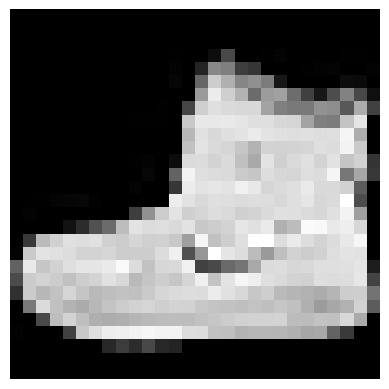

Image shape: torch.Size([1, 28, 28]) Label: 0


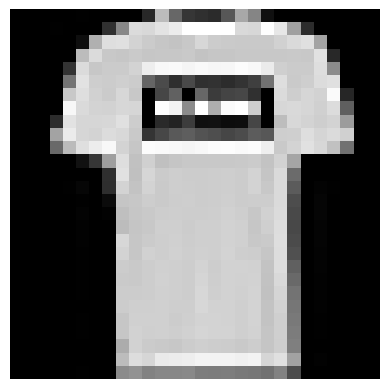

Image shape: torch.Size([1, 28, 28]) Label: 0


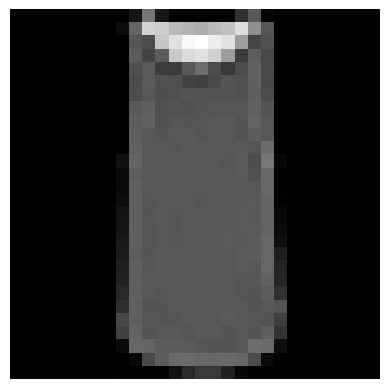

Image shape: torch.Size([1, 28, 28]) Label: 3


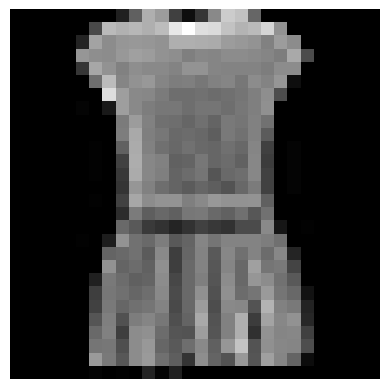

Image shape: torch.Size([1, 28, 28]) Label: 0


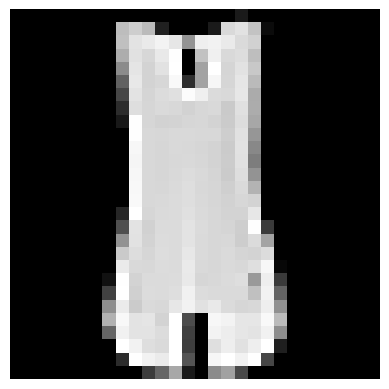

Image shape: torch.Size([1, 28, 28]) Label: 2


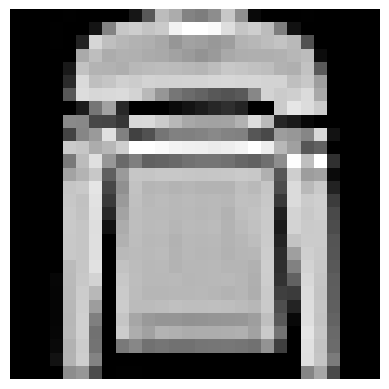

Image shape: torch.Size([1, 28, 28]) Label: -1


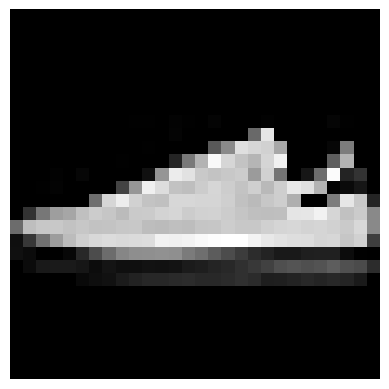

Image shape: torch.Size([1, 28, 28]) Label: 2


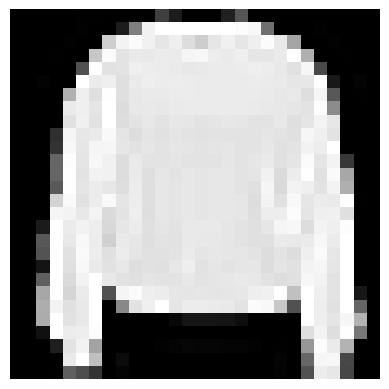

Image shape: torch.Size([1, 28, 28]) Label: 5


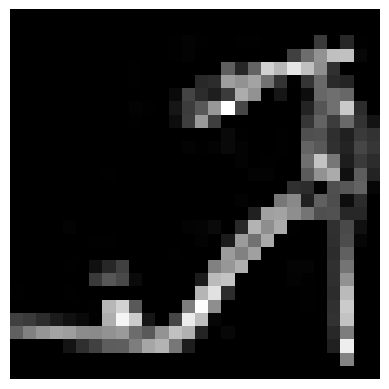

Image shape: torch.Size([1, 28, 28]) Label: 5


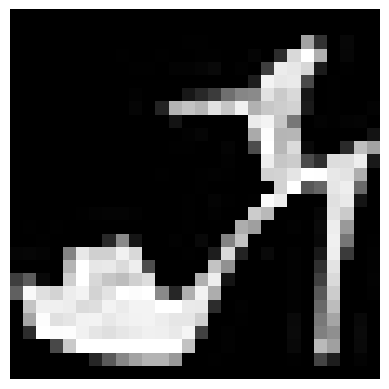

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def show_image(image):
    # Convert the PyTorch tensor to a numpy array and reshape it to (28, 28)
    image = np.squeeze(image.numpy())
    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Example: Display the first 10 images from the training dataset
for i in range(10):
    image, target = train_dataset_1[i]
    print("Image shape:", image.shape, "Label:", target)
    show_image(image)

In [156]:
train_dataset_2 = FashionMNISTtask2(root='./data2', train=True, transform=transform, download=True)
test_dataset_2 = FashionMNISTtask2(root='./data2', train=False, transform=transform, download=True)
test_dataset_3 = datasets.FashionMNIST(
    root='data3',
    train=False,
    download=True,
    transform=transform
)

In [157]:
train_dataset_filtered_first = [data for data in train_dataset_1 if data[1] != -1]
test_dataset_filtered_first = [data for data in test_dataset_1 if data[1] != -1]

train_dataset_filtered_second = [data for data in train_dataset_2 if data[1] != -1]
test_dataset_filtered_second = [data for data in test_dataset_2 if data[1] != -1]

In [158]:
unique_labels_1 = set()
unique_labels_2 = set()

for _, target in train_dataset_filtered_first:
    unique_labels_1.add(target)

for _, target in train_dataset_filtered_second:
    unique_labels_2.add(target)

print(f"First: {unique_labels_1}")
print(f"Second: {unique_labels_2}")

First: {0, 1, 2, 3, 4, 5}
Second: {8, 9, 6, 7}


In [159]:
train_dataloader_first = DataLoader(train_dataset_filtered_first, batch_size=64, shuffle=True)
test_dataloader_first = DataLoader(test_dataset_filtered_first, batch_size=256, shuffle=False)

for X, y in train_dataloader_first:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"SHape of y: {y.shape}, dtype: {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
SHape of y: torch.Size([64]), dtype: torch.int64


In [160]:
train_dataloader_second = DataLoader(train_dataset_filtered_second, batch_size=64, shuffle=True)
test_dataloader_second = DataLoader(test_dataset_filtered_second, batch_size=256, shuffle=False)

In [161]:
eval_dataloader = DataLoader(test_dataset_3, batch_size=256, shuffle=True)

In [162]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [163]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=10, hidden_size=512):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28*28, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.classifier = nn.Linear(hidden_size, num_classes)

    #     self._initialize_weights()

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.kaiming_normal_(m.weight, nonlinearity='sigmoid')
    #         elif isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        logits = self.classifier(x)

        return logits

In [164]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"Loss: {loss:>7f}, {current:>5d}/{size:>5d}")

In [165]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()

  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}, Avg Loss: {test_loss:>8f}\n")

In [166]:
model = NeuralNetwork(num_classes=10, hidden_size=512).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [167]:
epochs = 3
for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------")
  train(train_dataloader_first, model, loss_fn, optimizer)
  test(test_dataloader_first, model, loss_fn)
print("Done!")

torch.save(model.state_dict(), "model_old.pth")

Epoch 1
---------------------------
Loss: 2.290051,    64/36000
Loss: 0.376325,  6464/36000
Loss: 0.346875, 12864/36000
Loss: 0.275218, 19264/36000
Loss: 0.211062, 25664/36000
Loss: 0.223819, 32064/36000
Test Error: 
 Accuracy: 88.9, Avg Loss: 0.301338

Epoch 2
---------------------------
Loss: 0.399667,    64/36000
Loss: 0.289187,  6464/36000
Loss: 0.353504, 12864/36000
Loss: 0.220276, 19264/36000
Loss: 0.306884, 25664/36000
Loss: 0.255213, 32064/36000
Test Error: 
 Accuracy: 89.6, Avg Loss: 0.275398

Epoch 3
---------------------------
Loss: 0.166455,    64/36000
Loss: 0.263506,  6464/36000
Loss: 0.260480, 12864/36000
Loss: 0.280514, 19264/36000
Loss: 0.290238, 25664/36000
Loss: 0.292352, 32064/36000
Test Error: 
 Accuracy: 90.5, Avg Loss: 0.266529

Done!


In [168]:
def val(epoch):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(eval_dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted_old = outputs.max(1)
            print(predicted_old)
            total += len(y)
            correct += predicted_old.eq(y).sum().item()
        print(f"Validation Acc: {100. * correct / total}\n")

In [169]:
val(1)

tensor([5, 0, 5, 2, 3, 0, 4, 5, 5, 5, 0, 4, 2, 5, 4, 3, 5, 5, 4, 4, 0, 0, 0, 2,
        0, 0, 2, 2, 5, 5, 5, 5, 4, 1, 5, 5, 5, 5, 1, 4, 4, 1, 5, 0, 0, 1, 5, 5,
        3, 2, 1, 5, 5, 1, 5, 5, 5, 4, 2, 4, 5, 5, 5, 0, 2, 0, 5, 5, 2, 3, 3, 3,
        4, 4, 0, 3, 0, 4, 3, 2, 1, 5, 0, 2, 0, 0, 5, 0, 4, 2, 4, 5, 4, 5, 3, 2,
        5, 5, 5, 5, 2, 0, 3, 4, 0, 0, 3, 5, 5, 4, 0, 1, 0, 1, 5, 3, 5, 4, 2, 0,
        3, 5, 5, 5, 0, 2, 0, 4, 5, 1, 0, 4, 5, 4, 2, 3, 1, 5, 2, 0, 5, 5, 4, 5,
        0, 2, 5, 4, 3, 0, 1, 5, 0, 5, 3, 2, 5, 5, 3, 5, 5, 5, 1, 2, 5, 5, 2, 5,
        1, 5, 3, 1, 2, 5, 3, 0, 5, 0, 4, 2, 0, 3, 2, 0, 4, 4, 5, 5, 0, 5, 1, 0,
        5, 2, 5, 5, 3, 2, 1, 1, 4, 4, 5, 2, 5, 4, 2, 0, 5, 4, 5, 2, 3, 5, 3, 5,
        5, 2, 4, 3, 1, 2, 4, 2, 5, 5, 3, 3, 0, 2, 4, 3, 1, 3, 0, 3, 0, 4, 2, 0,
        5, 0, 5, 2, 5, 2, 5, 5, 2, 3, 3, 2, 5, 4, 5, 5])
tensor([5, 5, 2, 4, 0, 2, 1, 5, 1, 5, 5, 0, 5, 5, 4, 3, 0, 4, 2, 2, 2, 1, 0, 1,
        5, 3, 5, 5, 2, 1, 0, 4, 5, 5, 5, 2, 3, 0, 4, 5, 5, 2, 5

________

In [170]:
# model = NeuralNetwork()
# model.load_state_dict(torch.load("model_old.pth"))

In [171]:
from copy import deepcopy

def get_fisher_diag(model, dataset, params, empirical=False):
    fisher = {}
    params_dict = dict(params)
    for n, p in deepcopy(params_dict).items():
        p.data.zero_()
        fisher[n] = p.data.clone().detach().requires_grad_()

    model.eval()

    for input, gt_label in dataset:
        input, gt_label = input.to(device), gt_label.to(device)
        model.zero_grad()
        output = model(input)

        if empirical:
            label = torch.nn.functional.log_softmax(output, dim=1)
        else:
            label = gt_label

        # label = gt_label.repeat(output.size(0))
        negloglikelihood = torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(output, dim=1), label)
        negloglikelihood.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset.dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher


def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        if n in fisher:
            _loss = fisher[n] * (p - p_old[n]) ** 2
            loss += _loss.sum()
    return loss

In [172]:
model.to(device)

ewc_lambda = 0.1

fisher_matrix = get_fisher_diag(model, train_dataloader_first, model.named_parameters())
prev_params = {n: p.data.clone() for n, p in model.named_parameters()}

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [173]:
print(fisher_matrix)

{'fc1.weight': tensor([[7.0144e-08, 7.0143e-08, 7.0107e-08,  ..., 6.7220e-08, 6.9408e-08,
         7.0201e-08],
        [1.2443e-07, 1.2443e-07, 1.2432e-07,  ..., 1.2133e-07, 1.2508e-07,
         1.2461e-07],
        [1.5954e-08, 1.5953e-08, 1.5966e-08,  ..., 1.5181e-08, 1.5586e-08,
         1.5968e-08],
        ...,
        [7.1332e-09, 7.1197e-09, 7.0872e-09,  ..., 6.6002e-09, 6.9393e-09,
         7.0660e-09],
        [1.3719e-09, 1.3701e-09, 1.3662e-09,  ..., 1.1088e-09, 1.3093e-09,
         1.3627e-09],
        [9.9232e-08, 9.9229e-08, 9.9205e-08,  ..., 9.8608e-08, 9.9531e-08,
         9.9349e-08]], requires_grad=True), 'fc1.bias': tensor([7.0152e-08, 1.2443e-07, 1.5954e-08, 1.5353e-09, 9.8909e-11, 3.6117e-08,
        1.1840e-12, 7.1647e-10, 8.1507e-09, 1.2926e-07, 1.3513e-07, 5.5539e-08,
        8.2039e-09, 2.4971e-07, 5.3689e-11, 1.5100e-07, 1.1359e-08, 3.4281e-08,
        2.4150e-08, 5.6432e-11, 5.8570e-08, 1.3878e-08, 3.5874e-08, 9.7707e-09,
        7.0594e-08, 9.1246e-11, 5.43

In [174]:
def train(dataloader, model, loss_fn, optimizer, fisher_matrix, prev_params):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)

        # Original loss
        ce_loss = loss_fn(pred, y)

        # EWC loss
        ewc_loss = get_ewc_loss(model, fisher_matrix, prev_params)

        loss = ce_loss + ewc_lambda * ewc_loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"Loss: {loss:>7f}, {current:>5d}/{size:>5d}")

In [175]:
def val(epoch):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(eval_dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            print(y)
            _, predicted_old = outputs.max(1)
            total += len(y)
            correct += predicted_old.eq(y).sum().item()
        print(f"Validation Acc: {100. * correct / total}\n")

In [176]:
for epoch in range(3):
    print(f"Epoch {epoch+1}: ----------------------")
    train(train_dataloader_second, model, loss_fn, optimizer, fisher_matrix, prev_params)
    test(test_dataloader_second, model, loss_fn)
print("Done!")

Epoch 1: ----------------------
Loss: 11.758369,    64/24000
Loss: 0.081602,  6464/24000
Loss: 0.303874, 12864/24000
Loss: 0.070974, 19264/24000
Test Error: 
 Accuracy: 95.8, Avg Loss: 0.118531

Epoch 2: ----------------------
Loss: 0.129366,    64/24000
Loss: 0.120579,  6464/24000
Loss: 0.120792, 12864/24000
Loss: 0.033984, 19264/24000
Test Error: 
 Accuracy: 96.2, Avg Loss: 0.103084

Epoch 3: ----------------------
Loss: 0.162501,    64/24000
Loss: 0.049092,  6464/24000
Loss: 0.191616, 12864/24000
Loss: 0.028654, 19264/24000
Test Error: 
 Accuracy: 96.7, Avg Loss: 0.092145

Done!


In [ ]:
val(1)

In [181]:
fisher_matrix = get_fisher_diag(model, train_dataloader_first, model.named_parameters())

In [182]:
print(fisher_matrix)

{'fc1.weight': tensor([[3.8245e-11, 3.8245e-11, 3.8245e-11,  ..., 1.2485e-11, 1.2328e-11,
         2.4805e-11],
        [7.8698e-12, 7.8698e-12, 7.8698e-12,  ..., 2.2900e-14, 5.0570e-12,
         6.4111e-12],
        [2.1240e-11, 2.1240e-11, 2.1096e-11,  ..., 1.4405e-11, 1.9834e-11,
         2.1240e-11],
        ...,
        [5.1814e-04, 5.1811e-04, 5.1790e-04,  ..., 4.9400e-04, 5.1294e-04,
         5.1785e-04],
        [1.2231e-06, 1.2230e-06, 1.2224e-06,  ..., 1.0076e-06, 1.1920e-06,
         1.2217e-06],
        [5.8674e-06, 5.8668e-06, 5.8624e-06,  ..., 5.8906e-06, 5.8751e-06,
         5.8674e-06]], requires_grad=True), 'fc1.bias': tensor([3.8245e-11, 7.8698e-12, 2.1240e-11, 3.9743e-05, 2.6030e-08, 4.7503e-10,
        5.7038e-11, 3.9195e-08, 2.4688e-11, 1.6962e-10, 3.6497e-11, 9.6668e-10,
        2.2232e-05, 4.2485e-11, 2.2489e-09, 1.9208e-04, 3.9324e-08, 2.3227e-06,
        4.3882e-07, 7.1989e-08, 2.8736e-11, 1.4526e-08, 7.5405e-07, 7.6080e-11,
        4.4116e-11, 1.2728e-09, 2.59